In [76]:
import sys
import subprocess
# Check if pyspark is installed, if not, install it
try:
    import pyspark
    print("PySpark is already installed.")
except ImportError:
    print("PySpark not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyspark"])
    print("PySpark installed successfully.")

PySpark is already installed.


In [77]:
!gdown --id 1mnHABJPgkjhfwPpYWwn5LONVg31A0WWh

/home/mehdi/miniconda3/envs/data/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mnHABJPgkjhfwPpYWwn5LONVg31A0WWh
To: /home/mehdi/Documents/SQL/Heart_Disease_Dataset/heart.csv
100%|███████████████████████████████████████| 35.9k/35.9k [00:00<00:00, 808kB/s]


In [78]:
# creat a session spark
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("test_session") \
    .getOrCreate() 

In [79]:
df_heart = spark.read.csv('heart.csv', header=True, inferSchema=True, nanValue='Nan')


# Data checks & EDA

In [80]:
from pyspark.sql.functions import col, when

# Schema overview
df_heart.printSchema()

# Count rows and columns
n_rows = df_heart.count()
n_cols = len(df_heart.columns)
print(f"Dataset contains {n_rows} rows and {n_cols} columns")


root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)

Dataset contains 918 rows and 12 columns


- Missing Values Audit

In [81]:
from pyspark.sql import functions as F

# Split columns by dtype
numeric_cols  = [c for c, t in df_heart.dtypes if t in ("int", "double", "float", "bigint")]
string_cols   = [c for c, t in df_heart.dtypes if t == "string"]
boolean_cols  = [c for c, t in df_heart.dtypes if t in ("boolean", "bool")]

n_rows = df_heart.count()

# Missing for numeric: null or NaN
missing_numeric = df_heart.select([
    F.sum(F.when(F.col(c).isNull() | F.isnan(F.col(c)), 1).otherwise(0)).alias(c)
    for c in numeric_cols
])

# Missing for string: null, empty, or 'na'/'nan'
missing_string = df_heart.select([
    F.sum(
        F.when(
            F.col(c).isNull() |
            (F.trim(F.col(c)) == "") |
            (F.lower(F.trim(F.col(c))).isin("na", "nan")),
            1
        ).otherwise(0)
    ).alias(c)
    for c in string_cols
])

# Missing for boolean: only null
missing_boolean = df_heart.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in boolean_cols
])

print("=== Missing (numeric) ===")
missing_numeric.show(truncate=False)

print("=== Missing (string) ===")
missing_string.show(truncate=False)


# -------- Tidy combined report --------
rows = []

for c in numeric_cols:
    cnt = missing_numeric.select(c).first()[0]
    rows.append((c, "numeric", int(cnt), float(cnt)/n_rows))

for c in string_cols:
    cnt = missing_string.select(c).first()[0]
    rows.append((c, "string", int(cnt), float(cnt)/n_rows))

report_df = spark.createDataFrame(rows, ["column", "dtype", "n_missing", "pct_missing"])
report_df.orderBy(F.desc("pct_missing"), F.asc("column")).show(truncate=False)


=== Missing (numeric) ===
+---+---------+-----------+---------+-----+-------+------------+
|Age|RestingBP|Cholesterol|FastingBS|MaxHR|Oldpeak|HeartDisease|
+---+---------+-----------+---------+-----+-------+------------+
|0  |0        |0          |0        |0    |0      |0           |
+---+---------+-----------+---------+-----+-------+------------+

=== Missing (string) ===
+---+-------------+----------+--------------+--------+
|Sex|ChestPainType|RestingECG|ExerciseAngina|ST_Slope|
+---+-------------+----------+--------------+--------+
|0  |0            |0         |0             |0       |
+---+-------------+----------+--------------+--------+

+--------------+-------+---------+-----------+
|column        |dtype  |n_missing|pct_missing|
+--------------+-------+---------+-----------+
|Age           |numeric|0        |0.0        |
|ChestPainType |string |0        |0.0        |
|Cholesterol   |numeric|0        |0.0        |
|ExerciseAngina|string |0        |0.0        |
|FastingBS     |nu

- Target Class Balance

In [82]:
from pyspark.sql import functions as F

balance = (
    df_heart.groupBy("HeartDisease")
    .count()
    .withColumn("Percentage", F.round((F.col("count") / n_rows) * 100, 2))
)
balance.show()


+------------+-----+----------+
|HeartDisease|count|Percentage|
+------------+-----+----------+
|           1|  508|     55.34|
|           0|  410|     44.66|
+------------+-----+----------+



- # Numeric Summary Statistics

In [83]:
umeric_cols = [c for c, t in df_heart.dtypes if t in ("int", "double")]

df_heart.select(numeric_cols).describe().show(truncate=False)


+-------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|summary|Age               |RestingBP         |Cholesterol       |FastingBS          |MaxHR             |Oldpeak           |HeartDisease       |
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|count  |918               |918               |918               |918                |918               |918               |918                |
|mean   |53.510893246187365|132.39651416122004|198.7995642701525 |0.23311546840958605|136.80936819172112|0.8873638344226581|0.5533769063180828 |
|stddev |9.43261650673202  |18.514154119907808|109.38414455220345|0.42304562473930296|25.46033413825029 |1.0665701510493264|0.49741373828459706|
|min    |28                |0                 |0                 |0                  |60                |-2.6              |0     

- Invalid physiological ranges

In [84]:
invalid_bp   = df_heart.filter(F.col("RestingBP") <= 0).count()
invalid_chol = df_heart.filter(F.col("Cholesterol") <= 0).count()

print(f"Invalid RestingBP values: {invalid_bp}")
print(f"Invalid Cholesterol values: {invalid_chol}")

# Quick range checks
df_heart.selectExpr(
    "min(Age) as min_Age", "max(Age) as max_Age",
    "min(MaxHR) as min_MaxHR", "max(MaxHR) as max_MaxHR",
    "min(Oldpeak) as min_Oldpeak", "max(Oldpeak) as max_Oldpeak"
).show()


Invalid RestingBP values: 1
Invalid Cholesterol values: 172
+-------+-------+---------+---------+-----------+-----------+
|min_Age|max_Age|min_MaxHR|max_MaxHR|min_Oldpeak|max_Oldpeak|
+-------+-------+---------+---------+-----------+-----------+
|     28|     77|       60|      202|       -2.6|        6.2|
+-------+-------+---------+---------+-----------+-----------+



- Correlation analysis


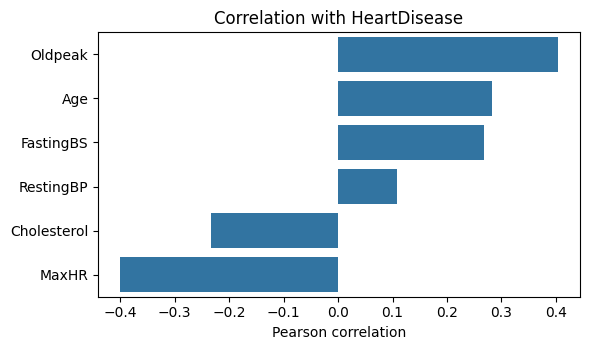

In [85]:

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Numeric label
df_e = df_heart.withColumn("label", F.col("HeartDisease").cast("int"))

# Pick numeric features + label
cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak", "FastingBS", "label"]

# To pandas
pdf = df_e.select(cols).toPandas()

# Correlations with label only
corr_with_label = (
    pdf.corr()[["label"]]
       .drop(index="label")                # drop label–label
       .rename(columns={"label":"corr"})   # nicer name
       .sort_values("corr", ascending=False)
)

# Using corr_with_label from above
corr_with_label["feature"] = corr_with_label.index

plt.figure(figsize=(6, 3.6))
sns.barplot(data=corr_with_label, x="corr", y="feature", orient="h")
plt.title("Correlation with HeartDisease")
plt.xlabel("Pearson correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()


- Full correlation matrix

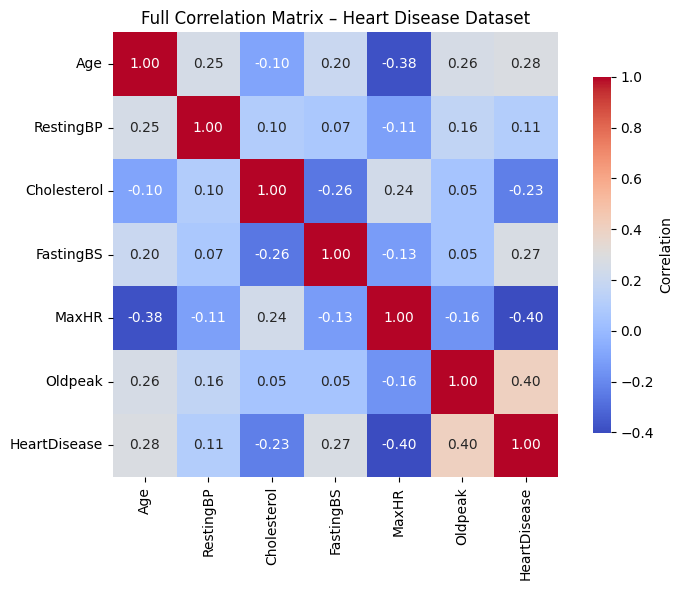

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Add numeric label for correlations
df_e = df_heart.withColumn("HeartDisease", F.col("HeartDisease").cast("int"))

# Select only numeric columns (including HeartDisease)
numeric_cols = ["Age", "RestingBP", "Cholesterol", "FastingBS",
                "MaxHR", "Oldpeak", "HeartDisease"]

# Convert to pandas for plotting
pdf = df_e.select(numeric_cols).toPandas()

# Compute correlation matrix
corr_matrix = pdf.corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f",
    cmap="coolwarm", square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)
plt.title("Full Correlation Matrix – Heart Disease Dataset")
plt.tight_layout()
plt.show()


- Distribution Visualization

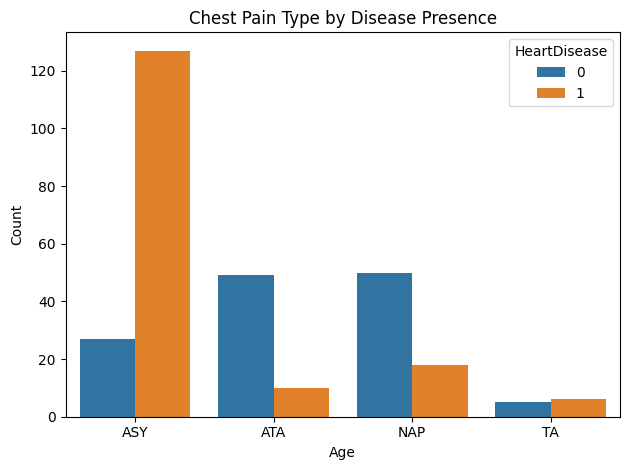

In [87]:
# 
pdf = df_heart.sample(fraction=0.3, seed=42).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

# Histogram for Age
sns.histplot(pdf, x="Age", hue="HeartDisease", bins=20, kde=True)
plt.title("Age Distribution by Heart Disease")

# MaxHR
sns.histplot(pdf, x="MaxHR", hue="HeartDisease", bins=20, kde=True)
plt.title("Maximum Heart Rate vs Disease")

# Chest Pain Types
sns.countplot(data=pdf, x="ChestPainType", hue="HeartDisease")
plt.title("Chest Pain Type by Disease Presence")

plt.tight_layout()
plt.show()


# Feature engineering

- Identify Feature Types

In [88]:
# Numerical and categorical features
numeric_cols = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

label_col = "HeartDisease"


- Encode Categorical Variables

In [89]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Index categorical columns
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="keep")
    for c in categorical_cols
]

# One-hot encode indexed columns
encoders = [
    OneHotEncoder(inputCols=[c + "_index"], outputCols=[c + "_vec"])
    for c in categorical_cols
]


- Scale Numerical Columns

In [90]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Assemble numeric columns
assembler_num = VectorAssembler(inputCols=numeric_cols, outputCol="num_features")

# Scale them
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_features", withMean=True, withStd=True)


- Assemble Final Feature Vector

In [91]:
# Collect all feature columns
encoded_vecs = [c + "_vec" for c in categorical_cols]

assembler_all = VectorAssembler(
    inputCols=["scaled_features"] + encoded_vecs,
    outputCol="features"
)


- Build Full Feature Engineering Pipeline

In [92]:
from pyspark.ml import Pipeline

stages = indexers + encoders + [assembler_num, scaler, assembler_all]
pipeline = Pipeline(stages=stages)

# Fit + transform the dataset
df_prepared = pipeline.fit(df_heart).transform(df_heart)

# Verify
df_prepared.select("features", "HeartDisease").show(3, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                    |HeartDisease|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|(20,[0,1,2,3,4,5,6,10,12,15,18],[-1.4323590105189428,0.41068502452423855,0.8246207537583257,-0.551040962906166,1.382174782828565,-0.8319788750413103,1.0,1.0,1.0,1.0,1.0])  |0           |
|(20,[0,1,2,3,4,5,7,9,12,15,17],[-0.4782229027298965,1.490939616252763,-0.17186736109802728,-0.551040962906166,0.7537462668036152,0.10560596081422916,1.0,1.0,1.0,1.0,1.0])  |1           |
|(20,[0,1,2,3,4,5,6,10,14,15,18],[-1.7504043797819582,-0.129

- Split Data

In [93]:
train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)
print(f"Train size: {train_df.count()} | Test size: {test_df.count()}")


Train size: 769 | Test size: 149


1. Logistic Regression (Baseline)

In [94]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize model
lr = LogisticRegression(
    labelCol="HeartDisease",
    featuresCol="features",
    elasticNetParam=0.5,   # 0=L2, 1=L1
    regParam=0.05,
    maxIter=100
)

# Train
lr_model = lr.fit(train_df)

# Evaluate
pred_lr = lr_model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", metricName="areaUnderROC")
roc_lr = evaluator.evaluate(pred_lr)
print(f"Logistic Regression AUC = {roc_lr:.3f}")



print("Intercept:", lr_model.intercept)
print(f"Coefficients: {lr_model.coefficients  }")


Logistic Regression AUC = 0.904
Intercept: -0.3496318542636248
Coefficients: [0.03221475239344427,0.0,-0.18034259947121126,0.2373542737493488,-0.07078291718191414,0.23522613234706974,0.4023818955849543,-0.4023818955849468,1.0117626373933597,0.0,-0.3275803692443902,0.0,0.0,0.0,0.0,-0.3219564603870267,0.3219564603870346,0.8208382261701177,-1.0417649312076822,0.0]


2. Decision Tree Classifier

In [95]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="HeartDisease", featuresCol="features", maxDepth=5)
dt_model = dt.fit(train_df)
pred_dt = dt_model.transform(test_df)
roc_dt = evaluator.evaluate(pred_dt)
print(f"Decision Tree AUC = {roc_dt:.3f}")


Decision Tree AUC = 0.854


3. Gradient Boosted Trees (GBT)

In [96]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="HeartDisease", featuresCol="features", maxIter=100, maxDepth=5)
gbt_model = gbt.fit(train_df)
pred_gbt = gbt_model.transform(test_df)
roc_gbt = evaluator.evaluate(pred_gbt)
print(f"GBT AUC = {roc_gbt:.3f}")


GBT AUC = 0.910


4. Random Forest Classifier

In [97]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="HeartDisease", featuresCol="features",
                            numTrees=100, maxDepth=7, seed=42)
rf_model = rf.fit(train_df)
pred_rf = rf_model.transform(test_df)
roc_rf = evaluator.evaluate(pred_rf)
print(f"Random Forest AUC = {roc_rf:.3f}")

# Feature importance
importances = rf_model.featureImportances
print("Top feature importances:", importances)


25/10/25 20:24:11 WARN DAGScheduler: Broadcasting large task binary with size 1343.6 KiB


Random Forest AUC = 0.919
Top feature importances: (20,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],[0.04704280045211147,0.04676582395954189,0.06970753278485367,0.026585288752248942,0.054269000801054824,0.0820069858434784,0.022005357449191434,0.02114870317511169,0.10494198128946408,0.006444540808983459,0.026737872212033397,0.005614245251457613,0.007082310185160095,0.01313790646896873,0.005190942552923115,0.057609761835349174,0.06264046171259045,0.13389099265117435,0.19685084439671305,0.010326647417590316])


25/10/25 20:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1170.9 KiB


- Compare Model Results

In [98]:
import pandas as pd
result_table = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "GBT"],
    "AUC": [roc_lr, roc_dt, roc_rf, roc_gbt]
})
print(result_table)


                 Model       AUC
0  Logistic Regression  0.904061
1        Decision Tree  0.854415
2        Random Forest  0.919151
3                  GBT  0.909650


In [99]:
from pyspark.sql import functions as F

# ensure target is 0/1 (int), not boolean
df_numeric = df_prepared.withColumn("label", F.col("HeartDisease").cast("int"))

models = {
    "LogReg": lr_model,
    "DecisionTree": dt_model,
    "RandomForest": rf_model,
    "GBT": gbt_model,
}

pdfs = {}
for name, m in models.items():
    # IMPORTANT: extract probability of class 1 as a scalar
    pred = (m.transform(df_numeric)
              .select(
                  F.col("label").alias("y_true"),
                  F.col("probability").alias("y_score"),
                  F.col("prediction").alias("y_pred")
              ))
    pdfs[name] = pred.toPandas()  # y_score is now float, not DenseVector


25/10/25 20:24:13 WARN DAGScheduler: Broadcasting large task binary with size 1095.6 KiB


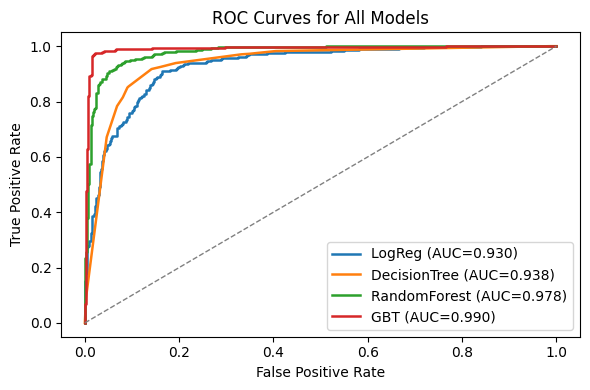

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

plt.figure(figsize=(6,4))
for name, pdf in pdfs.items():
    # probability column is still a DenseVector, extract element 1
    y_true = pdf["y_true"].astype(int)
    y_score = pdf["y_score"].apply(lambda v: v[1])  # extract prob for class 1
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.8, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],"--",color="gray",lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.tight_layout()
plt.show()


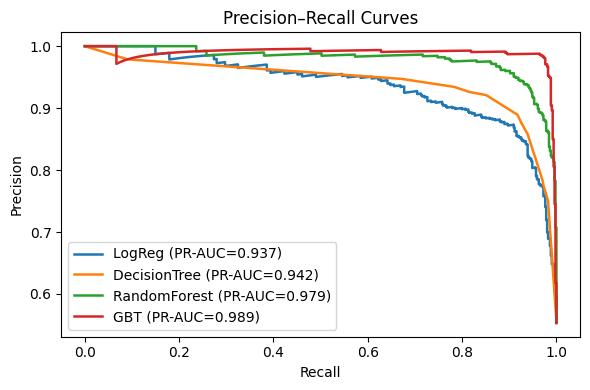

In [101]:
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(6,4))
for name, pdf in pdfs.items():
    y_true = pdf["y_true"].astype(int)
    y_score = pdf["y_score"].apply(lambda v: v[1])
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=1.8, label=f"{name} (PR-AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.tight_layout()
plt.show()


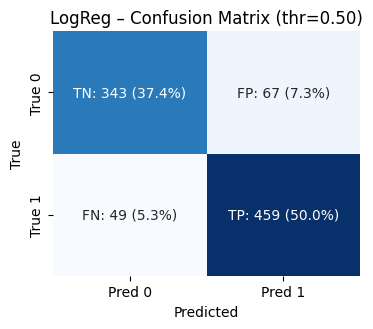

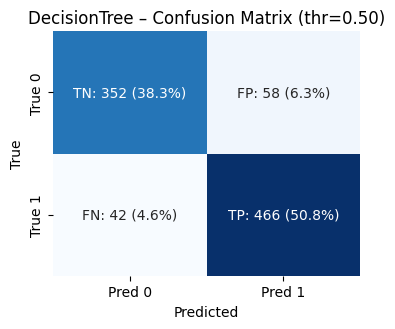

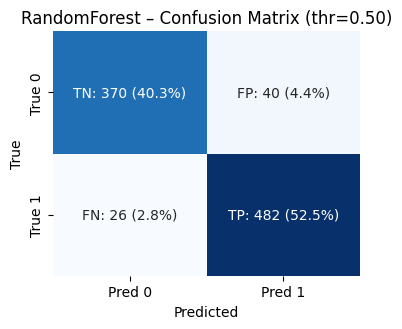

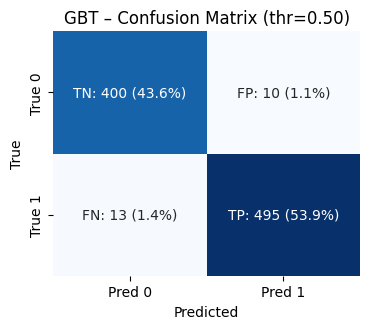

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm_with_pct(name, pdf, threshold=0.5):
    # extract arrays (remember: y_score is a DenseVector; take prob of class 1)
    y_true = pdf["y_true"].astype(int).values
    y_prob = np.array([v[1] for v in pdf["y_score"]])
    y_pred = (y_prob >= threshold).astype(int)

    # confusion matrix with labels [0,1] -> [[TN, FP],[FN, TP]]
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    pct = cm / total

    # labels with both count and percentage
    labels = np.array([
        [f"TN: {tn} ({pct[0,0]:.1%})", f"FP: {fp} ({pct[0,1]:.1%})"],
        [f"FN: {fn} ({pct[1,0]:.1%})", f"TP: {tp} ({pct[1,1]:.1%})"]
    ])

    plt.figure(figsize=(3.8, 3.4))
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", cbar=False,
                xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
    plt.title(f"{name} – Confusion Matrix (thr={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# plot for all models at threshold=0.5 (change as needed)
for name, pdf in pdfs.items():
    plot_cm_with_pct(name, pdf, threshold=0.5)


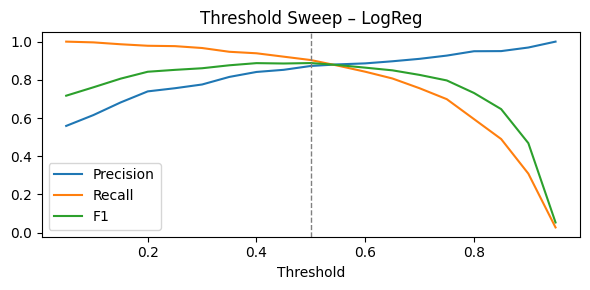

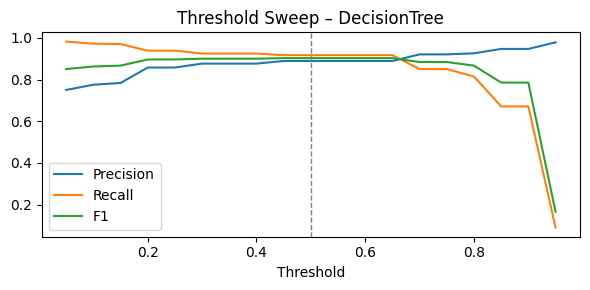

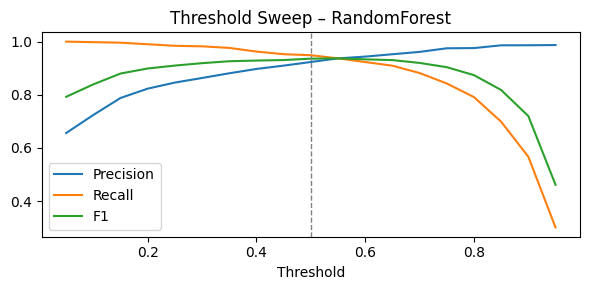

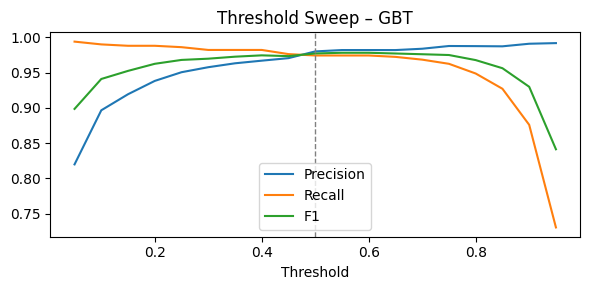

In [103]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def sweep_thresholds(y_true, y_score):
    thresholds = np.linspace(0.05, 0.95, 19)
    records = []
    for t in thresholds:
        preds = (y_score >= t).astype(int)
        p = precision_score(y_true, preds, zero_division=0)
        r = recall_score(y_true, preds, zero_division=0)
        f1 = f1_score(y_true, preds, zero_division=0)
        records.append((t, p, r, f1))
    return np.array(records)

for name, pdf in pdfs.items():
    y_true = pdf["y_true"].astype(int)
    y_score = np.array([v[1] for v in pdf["y_score"]])
    arr = sweep_thresholds(y_true, y_score)
    
    plt.figure(figsize=(6,3))
    plt.plot(arr[:,0], arr[:,1], label="Precision")
    plt.plot(arr[:,0], arr[:,2], label="Recall")
    plt.plot(arr[:,0], arr[:,3], label="F1")
    plt.axvline(0.5, ls="--", color="gray", lw=1)
    plt.title(f"Threshold Sweep – {name}")
    plt.xlabel("Threshold")
    plt.legend()
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_739923/2906550477.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(10), x="Coefficient", y="Feature", orient="h", palette="crest")


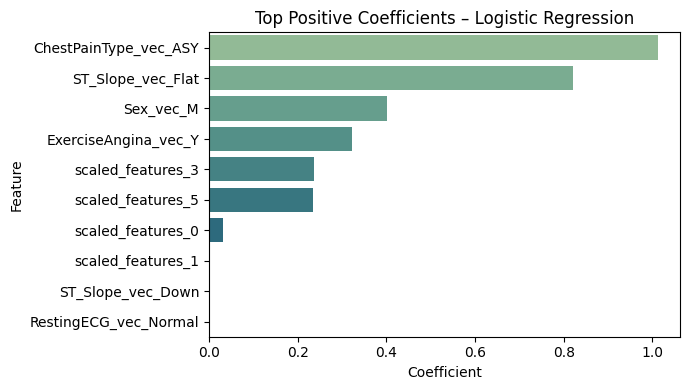

/tmp/ipykernel_739923/2906550477.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.tail(10), x="Coefficient", y="Feature", orient="h", palette="flare")


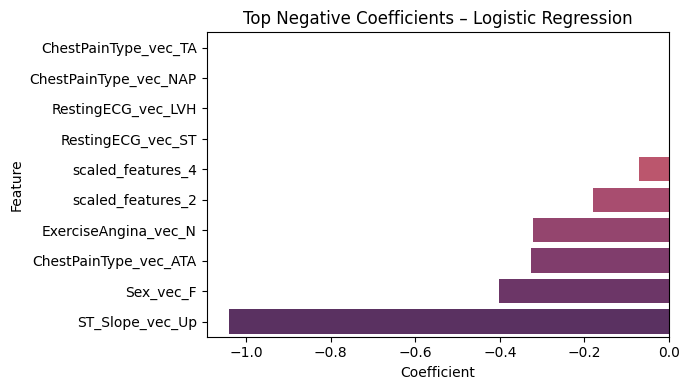

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure we have feature names (use same helper from before)
def get_feature_names(df, features_col="features"):
    meta = df.schema[features_col].metadata
    names = []
    try:
        attrs = meta.get("ml_attr", {}).get("attrs", {})
        collected = []
        for k in ["binary","numeric","nominal"]:
            for a in attrs.get(k, []):
                collected.append((a["idx"], a["name"]))
        if collected:
            names = [n for _, n in sorted(collected, key=lambda x: x[0])]
    except Exception:
        pass
    if not names:  # fallback, reconstruct manually
        from pyspark.sql import functions as F
        from pyspark.ml.functions import vector_to_array
        numeric_cols = ["Age","RestingBP","Cholesterol","FastingBS","MaxHR","Oldpeak"]
        categorical_cols = ["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"]
        names = [f"scaled_{c}" for c in numeric_cols]
        for c in categorical_cols:
            dim = df.select(F.size(vector_to_array(F.col(c + "_vec"))).alias("dim")).first()["dim"]
            names += [f"{c}__{i}" for i in range(dim)]
    return names

# get feature names (same as used for feature importances)
feature_names = get_feature_names(df_prepared)

# Extract coefficients
coef = np.array(lr_model.coefficients)

# make dataframe for plotting
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
}).sort_values("Coefficient", ascending=False)

# Plot top positive coefficients
plt.figure(figsize=(7,4))
sns.barplot(data=coef_df.head(10), x="Coefficient", y="Feature", orient="h", palette="crest")
plt.title("Top Positive Coefficients – Logistic Regression")
plt.tight_layout()
plt.show()

# Plot top negative coefficients
plt.figure(figsize=(7,4))
sns.barplot(data=coef_df.tail(10), x="Coefficient", y="Feature", orient="h", palette="flare")
plt.title("Top Negative Coefficients – Logistic Regression")
plt.tight_layout()
plt.show()


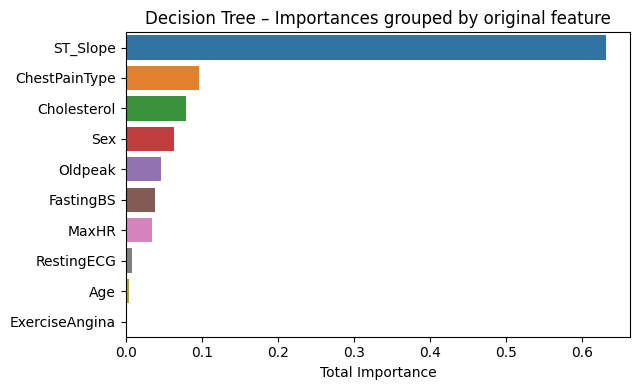

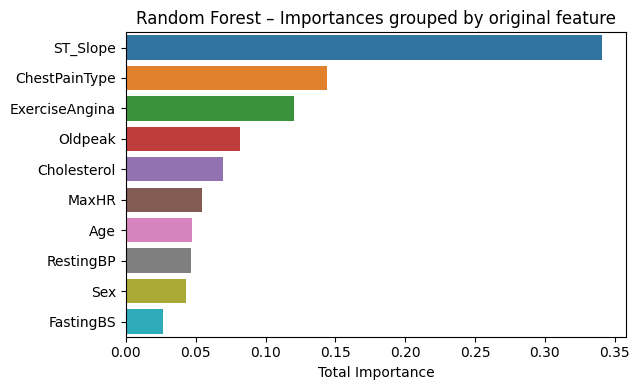

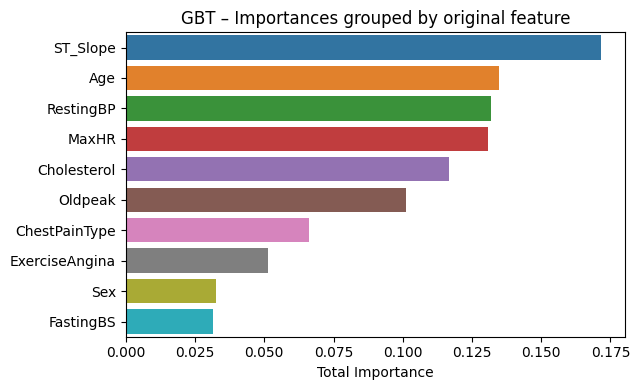

In [105]:
# --- grouped feature importances for ALL tree models (DT, RF, GBT) ---

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure we have feature_names; reuse your helper if needed
try:
    feature_names
except NameError:
    feature_names = get_feature_names(df_prepared)  # assumes you defined this earlier

# --- base feature mapping helper (same as your code) ---
num_map = {
    "scaled_features_0": "Age",
    "scaled_features_1": "RestingBP",
    "scaled_features_2": "Cholesterol",
    "scaled_features_3": "FastingBS",
    "scaled_features_4": "MaxHR",
    "scaled_features_5": "Oldpeak",
}
def base_feature(name: str) -> str:
    if name in num_map:
        return num_map[name]
    if "_vec_" in name:
        return name.split("_vec_")[0]
    if "__" in name:
        return name.split("__")[0]
    return name

def group_importances_any(model, feature_names):
    imp = model.featureImportances.toArray()
    df = pd.DataFrame({"Feature": feature_names, "Importance": imp})
    df["Base"] = df["Feature"].apply(base_feature)
    grouped = (df.groupby("Base", as_index=False)["Importance"]
                 .sum()
                 .sort_values("Importance", ascending=False))
    return grouped

# compute grouped importances
dt_grouped  = group_importances_any(dt_model,  feature_names)
rf_grouped  = group_importances_any(rf_model,  feature_names)
gbt_grouped = group_importances_any(gbt_model, feature_names)

# plot helper
def plot_grouped_imp(df, title, top_k=10):
    plt.figure(figsize=(6.5, 4))
    top = df.head(top_k)
    sns.barplot(data=top, x="Importance", y="Base", hue="Base", legend=False, orient="h")
    plt.title(title)
    plt.xlabel("Total Importance"); plt.ylabel("")
    plt.tight_layout(); plt.show()

# make the plots (same style)
plot_grouped_imp(dt_grouped,  "Decision Tree – Importances grouped by original feature", top_k=10)
plot_grouped_imp(rf_grouped,  "Random Forest – Importances grouped by original feature", top_k=10)
plot_grouped_imp(gbt_grouped, "GBT – Importances grouped by original feature", top_k=10)


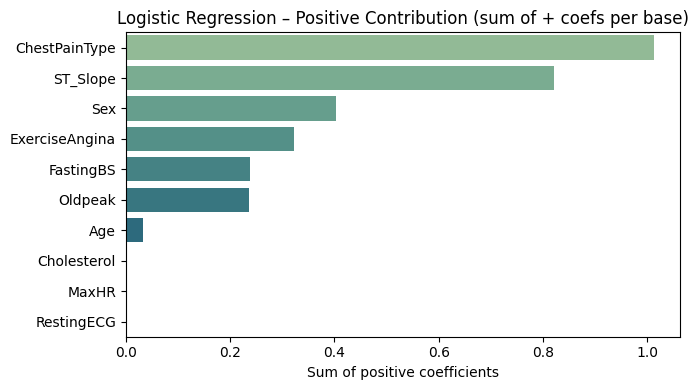

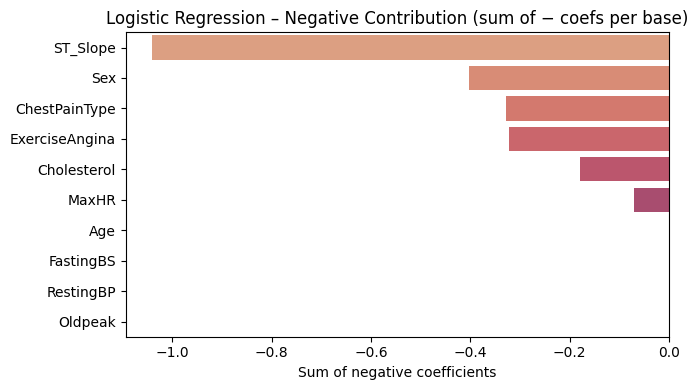

              Base   pos_sum   neg_sum   mean_signed  n_terms
1    ChestPainType  1.011763 -0.327580  1.710456e-01        4
9         ST_Slope  0.820838 -1.041765 -7.364224e-02        3
10             Sex  0.402382 -0.402382  3.747003e-15        2
3   ExerciseAngina  0.321956 -0.321956  3.969047e-15        2
4        FastingBS  0.237354  0.000000  2.373543e-01        1
6          Oldpeak  0.235226  0.000000  2.352261e-01        1
0              Age  0.032215  0.000000  3.221475e-02        1
2      Cholesterol  0.000000 -0.180343 -1.803426e-01        1
5            MaxHR  0.000000 -0.070783 -7.078292e-02        1
8       RestingECG  0.000000  0.000000  0.000000e+00        3
7        RestingBP  0.000000  0.000000  0.000000e+00        1
              Base   pos_sum   neg_sum   mean_signed  n_terms
9         ST_Slope  0.820838 -1.041765 -7.364224e-02        3
10             Sex  0.402382 -0.402382  3.747003e-15        2
1    ChestPainType  1.011763 -0.327580  1.710456e-01        4
3   Exer

In [106]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# 1) build coef_df with feature names
coef_df = pd.DataFrame({
    "Feature": feature_names,                          # from your features metadata helper
    "Coefficient": np.array(lr_model.coefficients)
})

# 2) map one-hot & scaled names -> base feature
num_map = {
    "scaled_features_0": "Age",
    "scaled_features_1": "RestingBP",
    "scaled_features_2": "Cholesterol",
    "scaled_features_3": "FastingBS",
    "scaled_features_4": "MaxHR",
    "scaled_features_5": "Oldpeak",
}
def base(name: str) -> str:
    if name in num_map:
        return num_map[name]
    if "_vec_" in name:   # e.g., ST_Slope_vec_Up
        return name.split("_vec_")[0]
    if "__" in name:      # fallback pattern e.g., ChestPainType__2
        return name.split("__")[0]
    return name

coef_df["Base"] = coef_df["Feature"].apply(base)

# 3) aggregate by sign **within** each base feature
grp = (coef_df.assign(pos=lambda d: d["Coefficient"].clip(lower=0.0),
                      neg=lambda d: d["Coefficient"].clip(upper=0.0))
               .groupby("Base", as_index=False)
               .agg(pos_sum=("pos","sum"),
                    neg_sum=("neg","sum"),      # will be ≤ 0
                    mean_signed=("Coefficient","mean"),
                    n_terms=("Coefficient","size")))

# 4) top positive & top negative contributors (signed sums)
top_pos = grp.sort_values("pos_sum", ascending=False).head(10)
top_neg = grp.sort_values("neg_sum", ascending=True).head(10)  # more negative first

# 5) plots (no FutureWarning: give hue=Base, legend=False)
plt.figure(figsize=(7,4))
sns.barplot(data=top_pos, x="pos_sum", y="Base", hue="Base", legend=False, orient="h", palette="crest")
plt.title("Logistic Regression – Positive Contribution (sum of + coefs per base)")
plt.xlabel("Sum of positive coefficients")
plt.ylabel("")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=top_neg, x="neg_sum", y="Base", hue="Base", legend=False, orient="h", palette="flare")
plt.title("Logistic Regression – Negative Contribution (sum of − coefs per base)")
plt.xlabel("Sum of negative coefficients")
plt.ylabel("")
plt.tight_layout(); plt.show()

# (optional) also see the table
display_cols = ["Base","pos_sum","neg_sum","mean_signed","n_terms"]
print(grp.sort_values(["pos_sum"], ascending=False)[display_cols].head(12))
print(grp.sort_values(["neg_sum"], ascending=True)[display_cols].head(12))


# (K-Means) Clustering on Heart Disease Data

Silhouette scores: [(2, 0.2899613059628792), (3, 0.30305981978481117), (4, 0.2744009327198203), (5, 0.2024266604890711), (6, 0.22426611467855506), (7, 0.22397257039586624)]
Best k=3 (silhouette=0.303)
+-------+---+--------+-------+---------+-----------+-----------+
|cluster|n  |pos_rate|avg_Age|avg_MaxHR|avg_Oldpeak|med_Oldpeak|
+-------+---+--------+-------+---------+-----------+-----------+
|0      |332|0.816   |57.8   |126.1    |1.7        |1.6        |
|1      |401|0.18    |48.3   |153.5    |0.27       |0.0        |
|2      |185|0.892   |57.0   |119.8    |0.77       |0.7        |
+-------+---+--------+-------+---------+-----------+-----------+


== ST_Slope distribution by cluster ==
+-------+--------+-----+---------+-----+
|cluster|ST_Slope|count|cluster_n|pct  |
+-------+--------+-----+---------+-----+
|0      |Flat    |261  |332      |0.786|
|0      |Up      |36   |332      |0.108|
|0      |Down    |35   |332      |0.105|
|1      |Up      |314  |401      |0.783|
|1      |Flat   

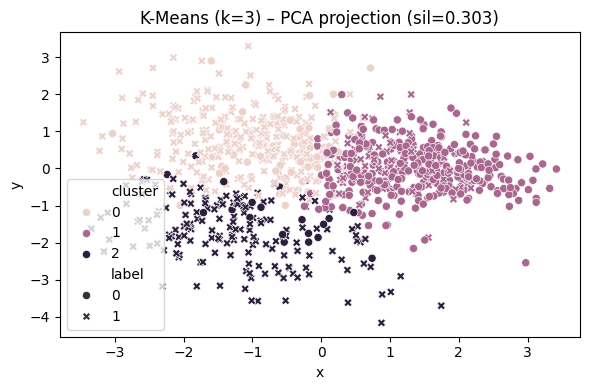

In [113]:
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA

# 0) Make sure label is available as 0/1 for summaries later
df_prep = df_prepared.withColumn("label", F.col("HeartDisease").cast("int"))

# 1) Pick k via silhouette on the vector you already have: 'features'
best = None
scores = []
for k in range(2, 8):
    km = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
    m  = km.fit(df_prep)
    pred = m.transform(df_prep)
    sil = ClusteringEvaluator(
        featuresCol="features", predictionCol="cluster",
        metricName="silhouette", distanceMeasure="squaredEuclidean"
    ).evaluate(pred)
    scores.append((k, sil))
    if best is None or sil > best[1]:
        best = (k, sil, m)
print("Silhouette scores:", scores)
print(f"Best k={best[0]} (silhouette={best[1]:.3f})")

# 2) Final assignments with best model
best_k, best_sil, kmeans_model = best
df_clusters = kmeans_model.transform(df_prep)  # adds 'cluster'

# 3) Label mix & basic stats per cluster (interpretation-friendly)
summary = (
    df_clusters.groupBy("cluster")
      .agg(
          F.count("*").alias("n"),
          F.round(F.avg("label"), 3).alias("pos_rate"),
          F.round(F.avg("Age"), 1).alias("avg_Age"),
          F.round(F.avg("MaxHR"), 1).alias("avg_MaxHR"),
          F.round(F.avg("Oldpeak"), 2).alias("avg_Oldpeak"),
          F.expr("percentile_approx(Oldpeak, 0.5)").alias("med_Oldpeak")
      )
      .orderBy("cluster")
)
summary.show(truncate=False)

for col in ["ST_Slope", "ChestPainType", "ExerciseAngina"]:
    totals = df_clusters.groupBy("cluster").count().withColumnRenamed("count","cluster_n")
    dist = (df_clusters.groupBy("cluster", col)
            .count()
            .join(totals, "cluster")
            .withColumn("pct", F.round(F.col("count")/F.col("cluster_n"), 3))
            .orderBy("cluster", F.desc("count")))
    print(f"\n== {col} distribution by cluster ==")
    dist.show(truncate=False)

# 4) 2D visualization via PCA (project features to 2D just for plotting)
pca = PCA(k=2, inputCol="features", outputCol="pca2")
pca_model = pca.fit(df_clusters)
df_pca = pca_model.transform(df_clusters)

pdf = df_pca.select("pca2", "cluster", "label").toPandas()
pdf["x"] = pdf["pca2"].apply(lambda v: float(v[0]))
pdf["y"] = pdf["pca2"].apply(lambda v: float(v[1]))

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.scatterplot(data=pdf, x="x", y="y", hue="cluster", style="label", s=35)
plt.title(f"K-Means (k={best_k}) – PCA projection (sil={best_sil:.3f})")
plt.tight_layout(); plt.show()
